# Recommendation Engine / System
## Proyecto: Recomendador de Repositorios de Github
### Usaremos Collaborative Filtering
Artículo completo en www.aprendemachinelearning.com

In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn

Tenemos un archivo con la información de los usuarios y sus identificadores, un archivo con la información de los repositorios y finalmente el archivo “ratings” que contiene la valoración por usuario de los repositorios. Como no tenemos REALMENTE una valoración del 1 al 5 -como podríamos tener por ejemplo al valorar películas-, la columna rating es el número de usuarios que tienen ese mismo repositorio dentro de nuestra base de datos.

In [47]:
df_users = pd.read_csv("Data/UsersGH.csv", sep=";")
df_repos = pd.read_csv("Data/Repos.csv",sep=";")
df_ratings = pd.read_csv("Data/ratings.csv", sep=";")


In [48]:
df_users.head()

,userId,username,name
0,1,iris9112,Isabel Ruiz Buriticá
1,2,dianaclarke,Diana
2,3,nateprewitt,Nate Prewitt
3,4,oldani,Ordanis Sanchez
4,5,waflessnet,waflessnet


In [49]:
df_repos.head()

,repoId,title,categories,stars
0,1,airbnb / javascript,completar,NaN
1,2,kamranahmedse / developer-roadmap,Roadmap to becoming a web developer in 2019,85800.0
2,3,microsoft / vscode,Visual Studio Code,80855.0
3,4,torvalds / linux,Linux kernel source tree,78761.0
4,5,ytdl-org / youtube-dl,Command-line program to download videos from Y...,53909.0


In [50]:
df_ratings.head()

,userId,repoId,rating
0,1,1,2
1,1,2,3
2,1,3,4
3,1,4,5
4,1,5,3


In [51]:
n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.repoId.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

30 users
167 items


(array([94., 62., 66., 28., 40., 12., 14.,  8.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <a list of 8 Patch objects>)

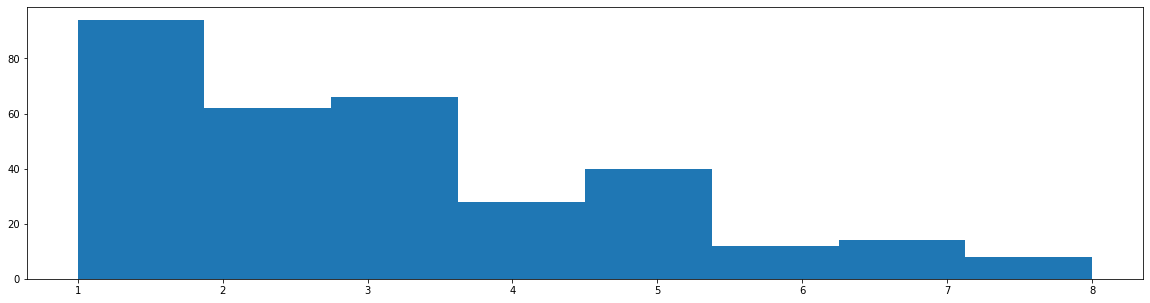

In [52]:
plt.hist(df_ratings.rating,bins=8)

Tenemos más de 80 valoraciones con una puntuación de 1 y unas 40 con puntuación en 5. Veamos las cantidades exactas,

In [53]:
df_ratings.groupby(["rating"])["userId"].count()

rating
1    94
2    62
3    66
4    28
5    40
6    12
7    14
8     8
Name: userId, dtype: int64

(array([94., 31., 22.,  7.,  8.,  2.,  2.,  1.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <a list of 8 Patch objects>)

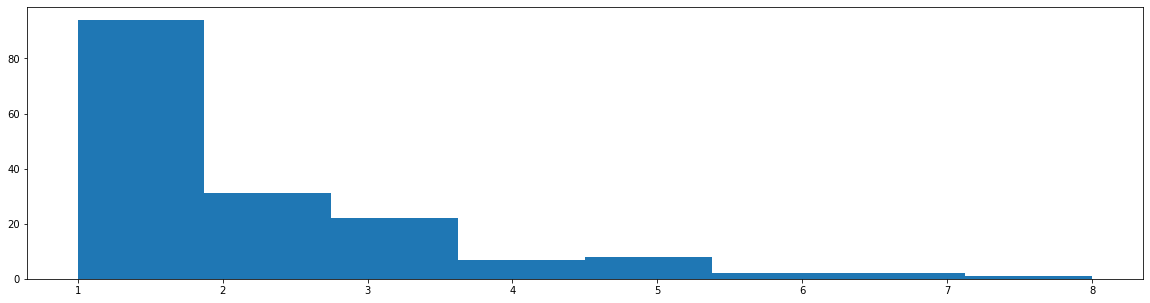

In [54]:
plt.hist(df_ratings.groupby(["repoId"])["repoId"].count(),bins=8)

Aquí vemos la cantidad de repositorios y cuantos usuarios “los tienen”. La mayoría de repos los tiene 1 sólo usuario, y no los demás. Hay unos 30 que los tienen 2 usuarios y unos 20 que coinciden 3 usuarios. La suma total debe dar 167.


# Método 1: User-Based

Collaborative Filtering intentará encontrar usuarios similares, para ofrecerle ítems “bien valorados” para ese perfil en concreto (lo que antes llamé “rellenar los huecos” en la matriz). Hay diversas maneras de medir ó calcular la similitud entre usuarios y de ello dependerá que se den buenas recomendaciones. Pero tengamos en cuenta que estamos hablando de buscar similitud entre “gustos” del usuario sobre esos ítems, me refiero a que no buscaremos perfiles similares por ser del mismo sexo, edad ó nivel educativo. Sólo nos valdremos de los ítems que ha experimentado, valorado (y podría ser su secuencia temporal) para agrupar usuarios “parecidos”.

Una de las maneras de medir esa similitud se llama “distancia por coseno de los vectores“ y por simplificar el concepto, digamos que crea un espacio vectorial con $n$ dimensiones correspondientes a los $n$ items y sitúa los vectores siendo su medida el “valor rating” de cada usuario -a ese item-. Luego calcula el ángulo entre los vectores partiendo de la “coordenada cero”. A “poca distancia” entre ángulos, se corresponde con usuarios con mayor similitud.

In [55]:
df_matrix = pd.pivot_table(df_ratings, values='rating', index='userId', columns='repoId').fillna(0)
df_matrix

repoId,1,2,3,4,5,6,7,8,9,10,...,158,159,160,161,162,163,164,165,166,167
userId,,,,,,,,,,,,,,,,,,,,,
1,2.0,3.0,4.0,5.0,3.0,1.0,5.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Una vez que tenemos la matriz de similitud, nos valdremos de otra operación matemática para calcular las recomendaciones.


[](https://www.aprendemachinelearning.com/wp-content/uploads/2019/08/rating_ponderado.png
)

$$R_u = \frac{\displaystyle\sum_{u=1}^{n} R_u \cdot Su}{\displaystyle\sum_{u=1}^n S_u}$$

FORMULA para calcular los ratings faltantes: sería algo así como “Matriz de similitud PROD.VECTORIAL ratings / (sumatoria de cada fila de ratings) Transpuesta
Lo haremos es: cada rating se multiplica por el factor de similitud de usuario que dio el rating. La predicción final por usuario será igual a la suma del peso de los ratings dividido por la “suma ponderada”.

In [56]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.43%


In [57]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, shuffle=False, random_state=42)

In [58]:
ratings_train.shape

(24, 167)

In [59]:
ratings_test.shape

(6, 167)

<ul>
<li>Matriz de similitud entre los usuarios (distancia del coseno -vectores-).</li>
<li>Predecir la valoración desconocida de un ítem i para un usuario activo u basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.</li>
<li>Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.</li>
</ul>

In [60]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)

In [61]:
sim_matrix.shape

(30, 30)

In [62]:
# sim_matrix

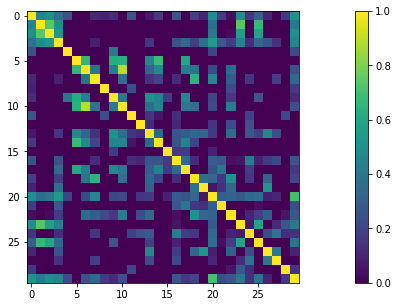

In [63]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

Cuanto más cercano a 1, mayor similitud entre esos usuarios.

In [64]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:24,0:24]
sim_matrix_test = sim_matrix[24:30,24:30]
print(sim_matrix_train.shape)
print(sim_matrix_test.shape)

(24, 24)
(6, 6)


## Predicciones (las recomendaciones!)

In [65]:
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

In [69]:
users_predictions.shape[0]

24

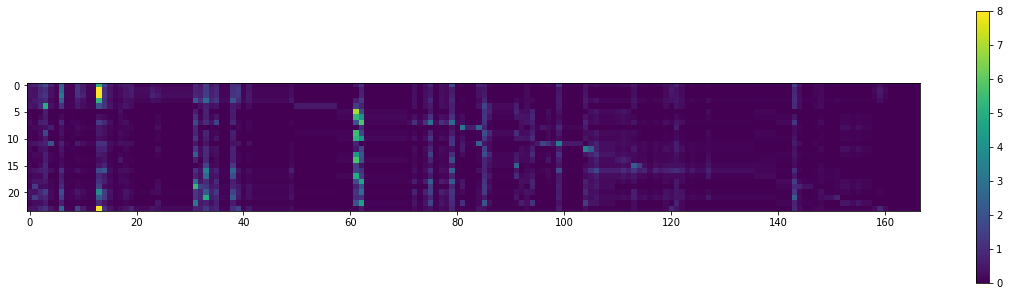

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

Vemos pocas recomendaciones que logren puntuar alto. La mayoría estará entre 1 y 2 puntos. Esto tiene que ver con nuestro dataset pequeño.

### Veamos un ejemplo

In [ ]:
USUARIO_EJEMPLO = 'jbagnato' # debe existir en nuestro dataset de train!
data = df_users[df_users['username'] == USUARIO_EJEMPLO]
usuario_ver = data.iloc[0]['userId'] -1 # resta 1 para obtener el index de pandas
user0=users_predictions.argsort()[usuario_ver]

# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
for i, aRepo in enumerate(user0[-3:]):
    selRepo = df_repos[df_repos['repoId']==(aRepo+1)]
    print(selRepo['title'] , 'puntaje:', users_predictions[usuario_ver][aRepo])

4    ytdl-org / youtube-dl
Name: title, dtype: object puntaje: 2.061791042203265
84    dipanjanS / practical-machine-learning-with-py...
Name: title, dtype: object puntaje: 2.4496166855518746
99    abhat222 / Data-Science--Cheat-Sheet
Name: title, dtype: object puntaje: 3.362878201910944


Vemos que los tres repositorios con mayor puntaje para sugerir a mi usuario son el de Data-Science–Cheat-Sheet con una puntuación de 3.36, practical-machine-learning-with-py con 2.44 y youtube-dl con 2.06. Lo cierto es que no son puntuaciones muy altas, pero tiene que ver con que la base de datos (nuestro csv) tiene muy pocos repositorios y usuarios cargados.

## Medir el Error

In [70]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)


In [71]:
get_mse(users_predictions, ratings_train)

3.3906497514974663

In [72]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[24:30,:]

get_mse(users_predictions_test, ratings_test)

4.722040854666231

Vemos que para el conjunto de train y test el MAE es bastante cercano. Un indicador de que no tiene buenas predicciones sería si el MAE en test fuera 2 veces más (ó la mitad) del valor del de train.

# Método 2: Usando Nearest Neighbors

In [4]:
k = 8
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train)

NameError: ignored

In [ ]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)
top_k_distances.shape

(24, 8)

In [ ]:
top_k_distances[usuario_ver]

array([ 0.        ,  7.87400787,  8.66025404,  8.83176087,  9.2736185 ,
       10.24695077, 10.63014581, 10.95445115])

In [ ]:
top_k_users.shape

(24, 8)

In [ ]:
res = top_k_users[usuario_ver]
res

array([11,  8, 15, 12,  4,  5, 19,  1])

In [ ]:
for a_index in res:
    print(df_users[df_users['userId'] == (a_index+1)])

    userId  username                  name
11      12  jbagnato  Juan Ignacio Bagnato
   userId      username         name
8       9  camiloyate09  Camilo Yate
    userId         username           name
15      16  Armando115Tapia  Armando Tapia
    userId         username                                name
12      13  otromaximiliano  Lindolfo Maximiliano Ayala Aguirre
   userId    username        name
4       5  waflessnet  waflessnet
   userId   username                name
5       6  luisbalru  Luis Balderas Ruiz
    userId    username               name
19      20  diazandr3s  Andres Diaz-Pinto
   userId     username   name
1       2  dianaclarke  Diana


In [ ]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [ ]:
users_predicts_k.shape

(24, 167)

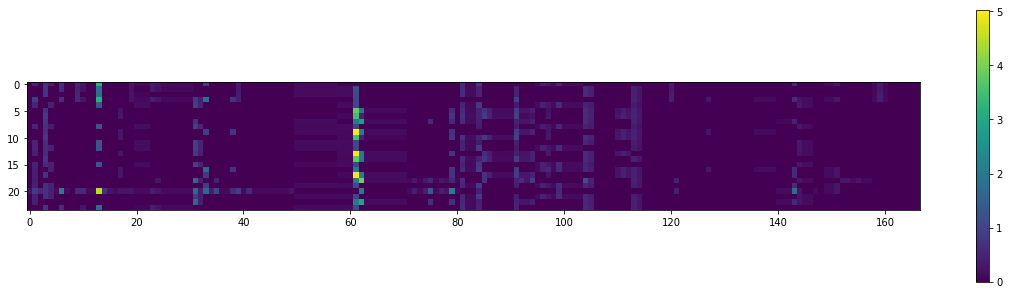

In [ ]:
plt.imshow(users_predicts_k);
plt.colorbar()
plt.show()

In [ ]:
user0=users_predicts_k.argsort()[usuario_ver][-4:]
# los tres con mayor puntaje en la predic para este usuario
# agrego 4 puesto que uno es mi propio repositorio
for aRepo in user0:
    selRepo = df_repos[df_repos['repoId'] == (aRepo+1)]
    print(selRepo['title'], 'puntaje:', users_predicts_k[usuario_ver][aRepo])

3    torvalds / linux
Name: title, dtype: object puntaje: 0.6975667679985449
31    freeCodeCamp / freeCodeCamp
Name: title, dtype: object puntaje: 0.9595266134630276
61    jbagnato / machine-learning
Name: title, dtype: object puntaje: 1.0790939117855096
13    python / cpython
Name: title, dtype: object puntaje: 1.3183999040179721


In [ ]:
get_mse(users_predicts_k, ratings_train)

8.124686270208018

In [ ]:
get_mse(users_predicts_k, ratings_test)

13.755121956634824

# Método 3: Collaborative Filtering Basado en Items

In [ ]:
#basado en items
n_repos = ratings_train.shape[1]
n_repos

167

In [ ]:
neighbors = NearestNeighbors(n_repos, 'cosine')
neighbors.fit(ratings_train.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=167, p=2,
                 radius='cosine')

In [ ]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)
top_k_distances.shape

(167, 167)

In [ ]:
top_k_items

array([[  0,  15,  18, ...,  62,  13,  61],
       [  1, 144, 151, ...,  62,  13,  61],
       [  2,   0,  18, ...,  62,  13,  61],
       ...,
       [164, 163, 162, ...,  62,  61,  13],
       [164, 163, 162, ...,  62,  61,  13],
       [164, 163, 162, ...,  62,  61,  13]])

In [ ]:
data = df_repos[df_repos['title'] == 'jbagnato / machine-learning']
repo_ver = data.iloc[0]['repoId'] -1
#print(repo_ver)

In [ ]:
df_repos[df_repos['repoId'].isin([repo_ver+1])]

,repoId,title,categories,stars
61,62,jbagnato / machine-learning,"Código Python, Jupyter Notebooks, archivos csv...",48.0


In [ ]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

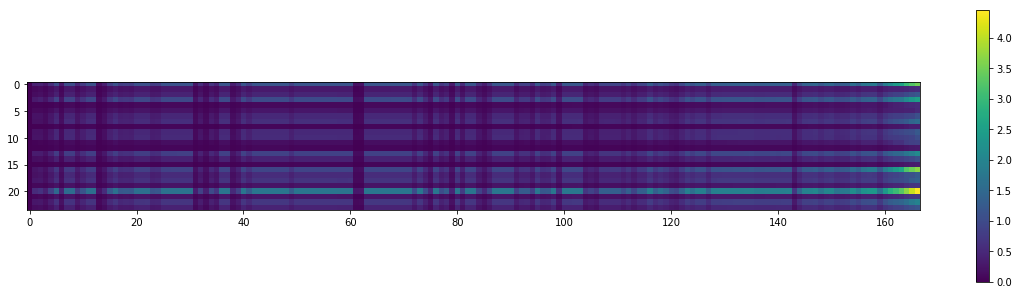

In [ ]:
plt.imshow(item_preds);
plt.colorbar()
plt.show()

In [ ]:
user0=item_preds.argsort()[usuario_ver]
user0

# los tres con mayor puntaje en la predic para este usuario
for aRepo in user0[-3:]:
    selRepo = df_repos[df_repos['repoId']==(aRepo+1)]
    print(selRepo['title'], 'puntaje:', item_preds[usuario_ver][aRepo])

164    nodejs / node
Name: title, dtype: object puntaje: 0.7915561710178032
165    OWASP / CheatSheetSeries
Name: title, dtype: object puntaje: 0.836463821866165
166    explosion / spaCy
Name: title, dtype: object puntaje: 0.8728575365246009


In [ ]:
get_mse(item_preds, ratings_train)

10.03834337791184

In [ ]:
get_mse(item_preds, ratings_test)

13.482774653471974

# Método 4: recomendacion por Correlacion 

In [ ]:
average_rating = pd.DataFrame(df_ratings.groupby('repoId')['rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(df_ratings.groupby('repoId')['rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

mi_repo_ratings = df_matrix[62]
similar_to_mine = df_matrix.corrwith(mi_repo_ratings)
corr_mine = pd.DataFrame(similar_to_mine, columns=['pearsonR'])
corr_mine.dropna(inplace=True)
corr_summary = corr_mine.join(average_rating['rating'])
corr_summary[corr_summary['rating']>=1].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,rating
repoId,,
62,1.000000,7
87,0.341515,3
92,0.341515,3
95,0.341515,3
139,0.336601,1
138,0.336601,1
137,0.336601,1
140,0.336601,1
88,0.336601,1


In [ ]:
# Veamos uno de los recomendados
df_repos[df_repos['repoId'] == 92]

,repoId,title,categories,stars
91,92,joanby / python-ml-course,Curso de Introducción a Machine Learning con P...,156.0


# Método 5: Repo mas popular -sin collaborative filtering-

Esta es la manera básica y sin uso de machine learning de ofrecer recomendaciones. <br>
estas no serán personalizadas, serán iguales para cualquier usuario

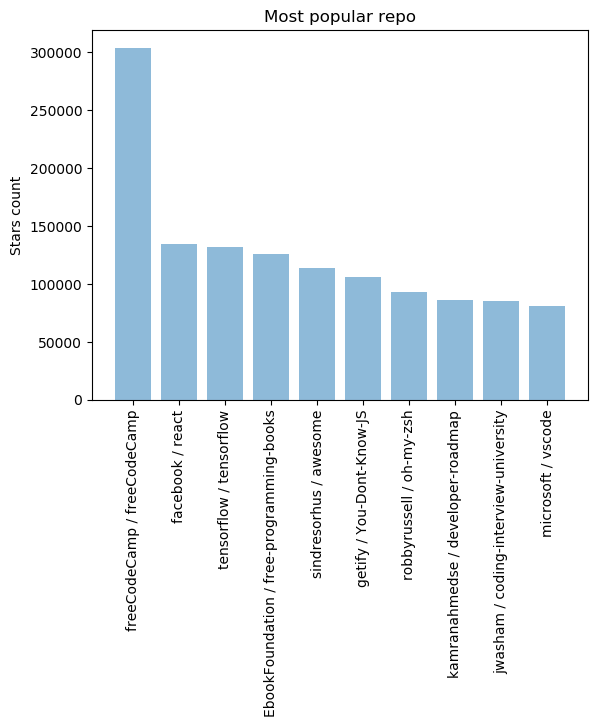

In [ ]:
popular_repo = df_repos[['title','stars']].groupby('stars').sum().reset_index()
popular_repo_top_20 = popular_repo.sort_values('stars', ascending=False).head(n=10)

plt.rcdefaults()
 
objects = (list(popular_repo_top_20['title']))
y_pos = np.arange(len(objects))
performance = list(popular_repo_top_20['stars'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Stars count')
plt.title('Most popular repo')
 
plt.show()